In [11]:
import datetime

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import scipy as sp
import pingouin as pg
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split

In [12]:
def get_corr_mat(df, corr_type='pearson'):
    cols = df.columns
    p_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)
    r_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)

    if corr_type == 'pearson':
        corr_func = sp.stats.pearsonr
    elif corr_type == 'spearman':
        corr_func = sp.stats.spearmanr
    elif corr_type == 'kendall':
        corr_func = sp.stats.kendalltau
    else:
        raise ValueError("Unsupported correlation type. Use 'pearson', 'spearman' or 'kendall'.")

    for i, col1 in enumerate(cols):
        for j, col2 in enumerate(cols):
            if i == j:
                p_matrix.loc[col1, col2] = 1.0
                r_matrix.loc[col1, col2] = 1.0
            else:
                arr1 = df[col1]
                arr2 = df[col2]

                stat = corr_func(arr1.astype(float), arr2.astype(float))
                r_matrix.loc[col1, col2] = stat.correlation
                p_matrix.loc[col1, col2] = stat.pvalue

    return r_matrix, p_matrix

def partial_correlation(x, y, z, corr_type='pearson'):
    x = np.array(x, dtype=float).ravel()
    y = np.array(y, dtype=float).ravel()

    if not isinstance(z, (list, tuple)):
        z = [z]

    z = [np.array(var, dtype=float).ravel() for var in z]

    lengths = np.unique([len(arr) for arr in [x, y, *z]])
    if len(lengths) > 1:
        raise ValueError("Все массивы (x, y и z) должны быть одинаковой длины.")

    data = pd.DataFrame({'x': x, 'y': y})
    for i, z_var in enumerate(z):
        data[f'z{i}'] = z_var

    covar_names = [f'z{i}' for i in range(len(z))]

    result = pg.partial_corr(data=data, x='x', y='y', covar=covar_names, method=corr_type)

    r = result['r'].values[0]
    p = result['p-val'].values[0]

    return r, p


def get_partial_corr_mat(df, corr_type='pearson'):
    cols = df.columns
    n = len(cols)

    corr_matrix = pd.DataFrame(np.eye(n), columns=cols, index=cols)
    pval_matrix = pd.DataFrame(np.eye(n), columns=cols, index=cols)

    for i in range(n):
        for j in range(i + 1, n):
            var1, var2 = cols[i], cols[j]
            covars = [col for col in cols if col not in (var1, var2)]

            x = df[var1]
            y = df[var2]
            z = [df[covar] for covar in covars]

            r, p = partial_correlation(x, y, z, corr_type=corr_type)

            corr_matrix.loc[var1, var2] = r
            corr_matrix.loc[var2, var1] = r
            pval_matrix.loc[var1, var2] = p
            pval_matrix.loc[var2, var1] = p

    return corr_matrix, pval_matrix

def cohens_d(group1, group2):
    mean_diff = np.mean(group1) - np.mean(group2)

    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)

    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))

    d = mean_diff / pooled_std
    return d

In [13]:
deals = pd.read_csv('../data/deals.csv')
flats = pd.read_csv('../data/flats.csv')

In [14]:
deals['Дата ввода в эксплуатацию'] = pd.to_datetime(deals['Дата ввода в эксплуатацию'])
deals['Плановая дата РВЭ'] = pd.to_datetime(deals['Плановая дата РВЭ'])
deals['Дата договора (месяц.год)'] = pd.to_datetime(deals['Дата договора (месяц.год)'])
deals['Дата начала продаж'] = pd.to_datetime(deals['Дата начала продаж'])

deals['Дней после начала продаж'] = (deals['Дата договора (месяц.год)'] - deals['Дата начала продаж']).dt.days
deals['Дней до ввода в эксплуатацию'] = (deals['Дата ввода в эксплуатацию'] - deals['Дата договора (месяц.год)']).dt.days
deals['Дней между началом продаж и вводом в эксплуатацию'] = (deals['Дата ввода в эксплуатацию'] - deals['Дата начала продаж']).dt.days

deals = deals.sort_values(by='Дата договора (месяц.год)')
deals['Задержка в днях'] = (
    deals['Плановая дата РВЭ'] -
    deals.groupby('ID корпуса')['Дата ввода в эксплуатацию'].transform('first')
).dt.days
deals['Задержка'] = deals['Задержка в днях'] > 0
deals['Сдача в срок'] = deals['Задержка в днях'] == 0
deals['Ранняя сдача'] = deals['Задержка в днях'] < 0

deals['Уступка'] = deals['Уступка'].apply(lambda val: val if isinstance(val, bool) else val == 'Договор уступки')

result = deals.groupby('ID корпуса').agg(
    total=('Уступка', 'size'),
    assignments=('Уступка', 'sum')
)

assignment_rates = (
    deals.groupby('Название ЖК')
    .agg(
        total=('Уступка', 'size'),
        assignments=('Уступка', 'sum')
    )
    .reset_index()
)

assignment_rates['percent_assignment'] = (assignment_rates['assignments'] / assignment_rates['total']) * 100

# Мержим обратно
deals = pd.merge(
    deals,
    assignment_rates[['Название ЖК', 'percent_assignment']],
    on='Название ЖК',
    how='left'
)


In [15]:
def filter(df, condition):
    prev = len(df)
    df = df[condition]
    print(len(df) / prev)
    return df

print('Before:', len(deals))
deals = filter(deals, deals['Цена квадратного метра'] < 100_000_000) # Удалили inf
deals = filter(deals, deals['Дата ввода в эксплуатацию'] <= datetime.datetime(2025, 12, 1)) # Удаляем еще не сданные дома
deals = filter(deals, ~np.isnan(deals['Плановая дата РВЭ'])) # Удалим один NaN
deals = filter(deals, deals['Дней после начала продаж'] <= 1200)
print('After:', len(deals))

Before: 50955
0.9835933666961044
0.672559308844949
0.9999703334519995
0.9930874892455573
After: 33474


In [16]:
delay_mu = deals.drop_duplicates(subset=['ID корпуса'], keep='first')['Задержка'].sum() / len(deals.drop_duplicates(subset=['ID корпуса'], keep='first'))
print(f'Процент задерженных лотов: {(100 * delay_mu):.2f}%')

Процент задерженных лотов: 67.18%


<Axes: >

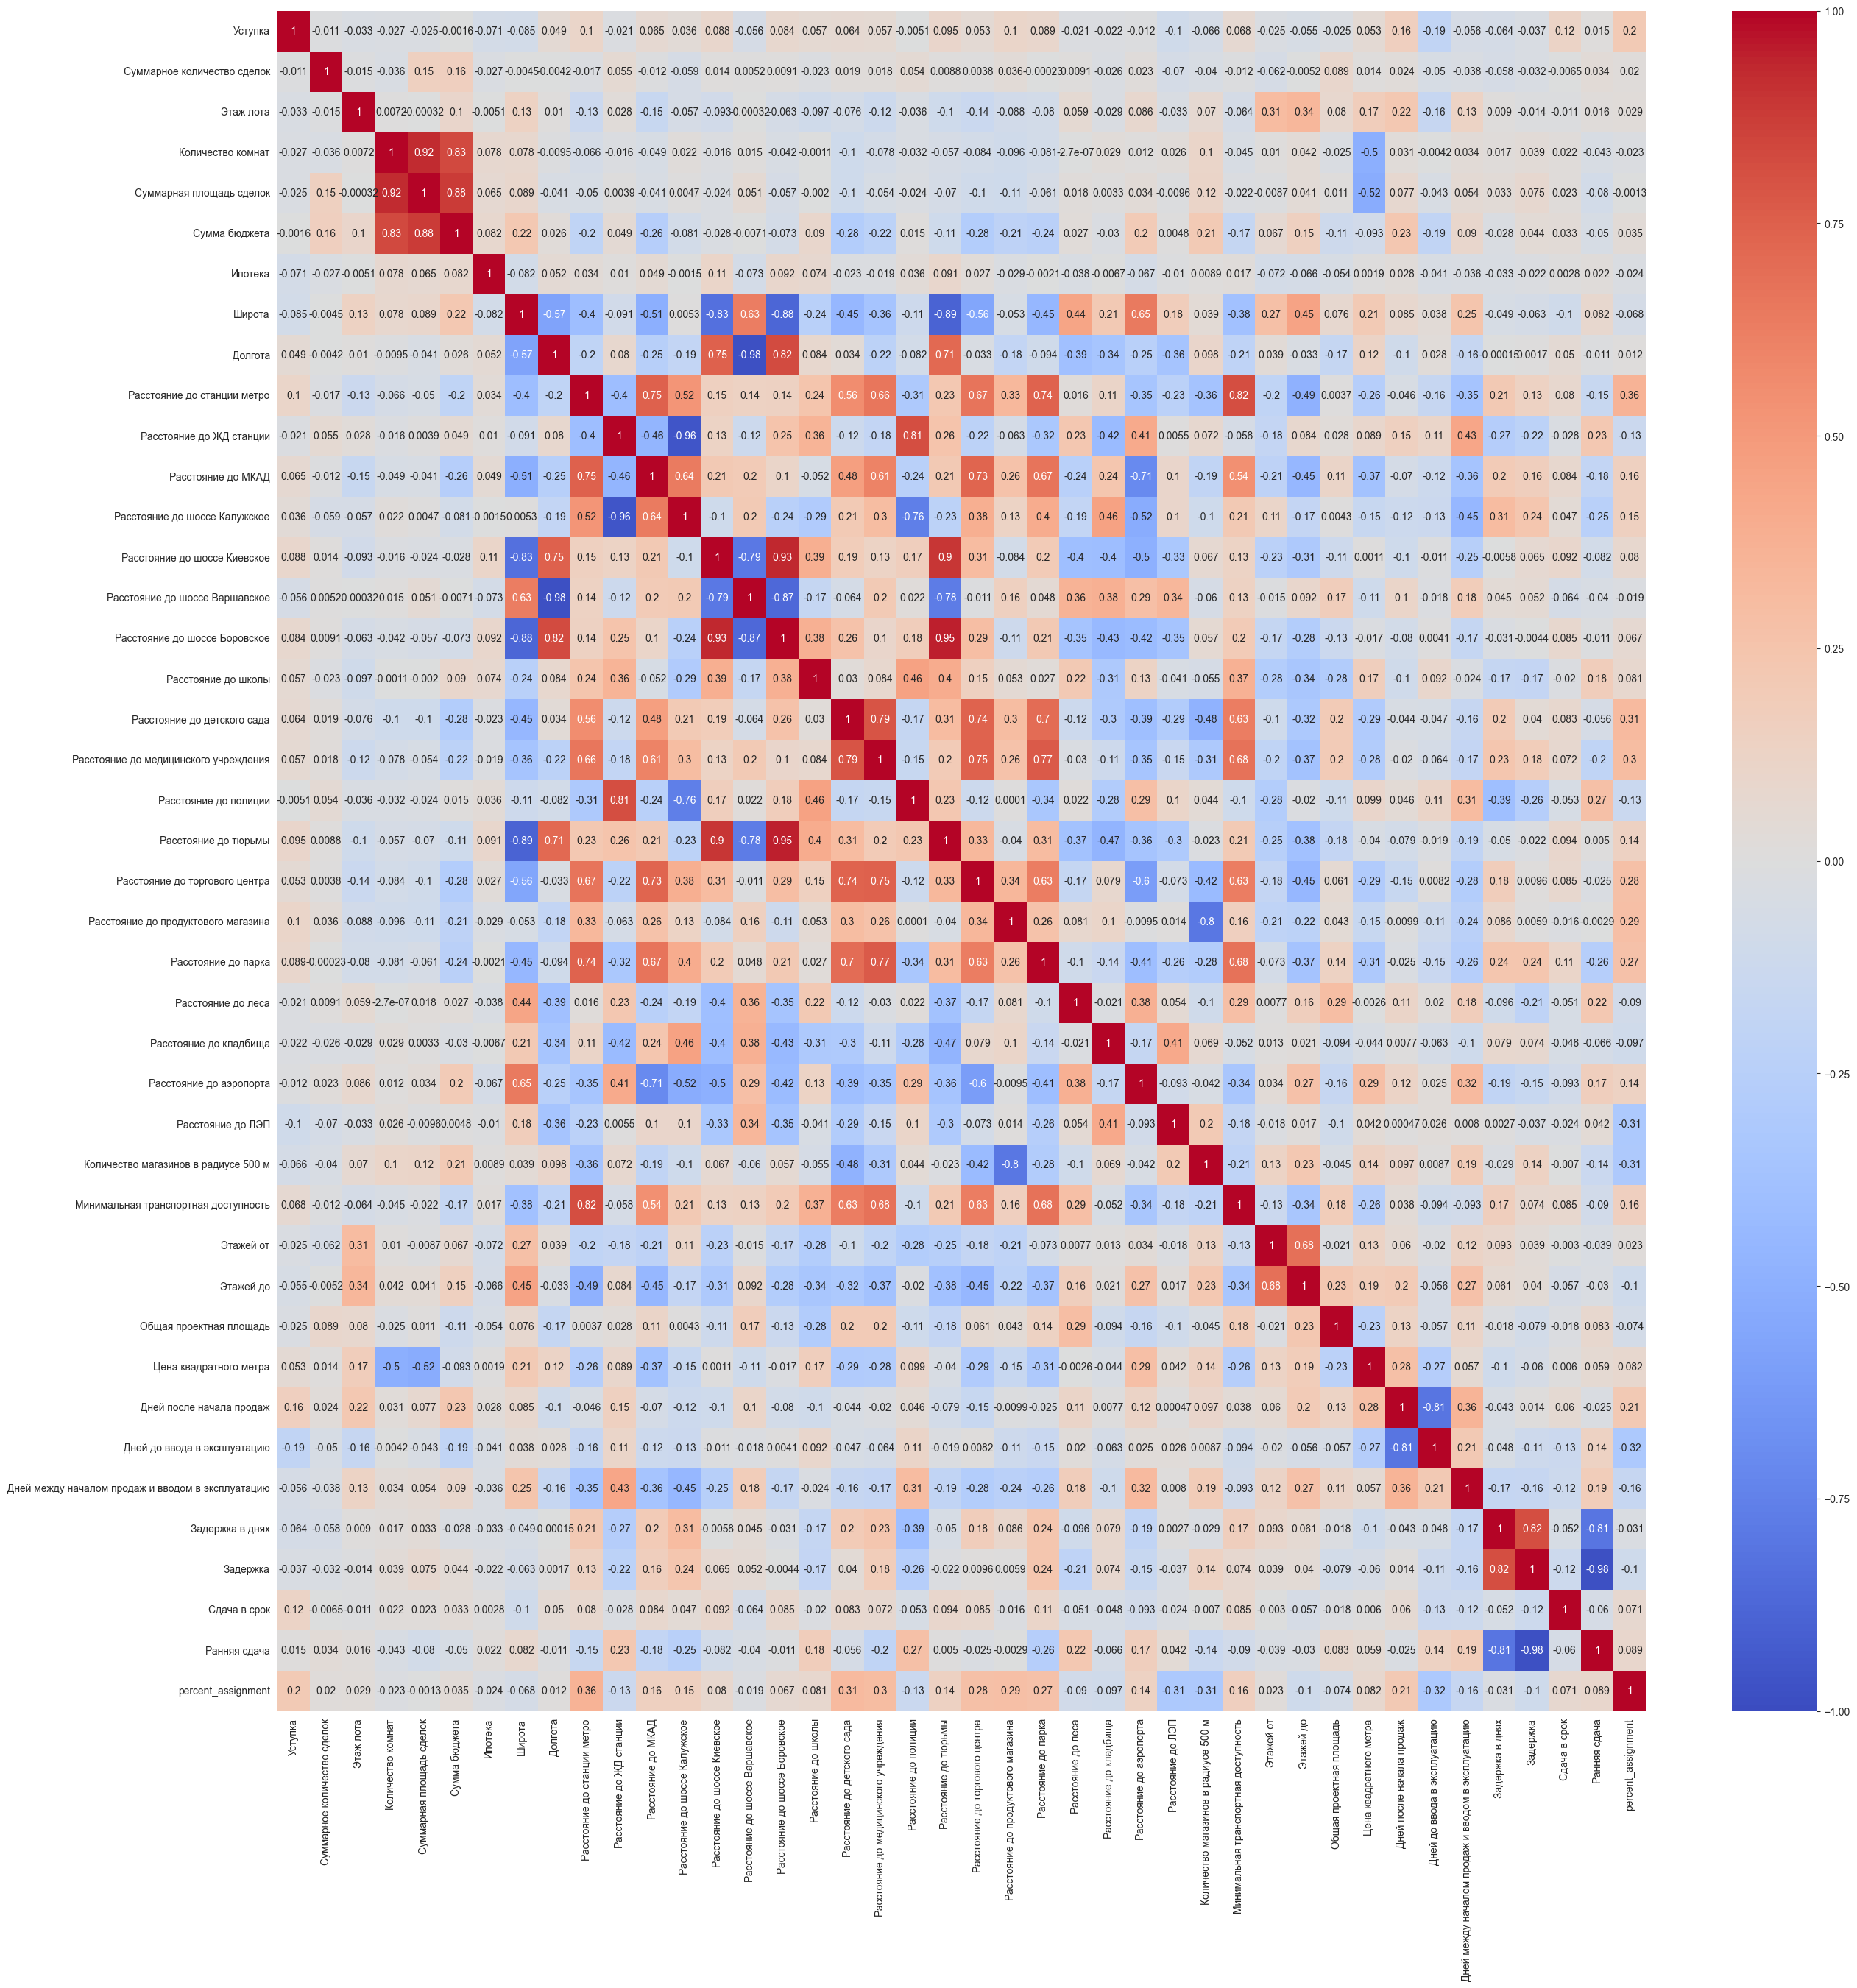

In [17]:
df = deals.copy()
numerical_cols = df.select_dtypes(include=['number', 'bool']).columns.tolist()
df = df[numerical_cols]

mat, _ = get_corr_mat(df, corr_type='spearman')
plt.figure(figsize=(30, 30))
sns.heatmap(data=mat, vmin=-1, vmax=1, cmap='coolwarm', annot=True)

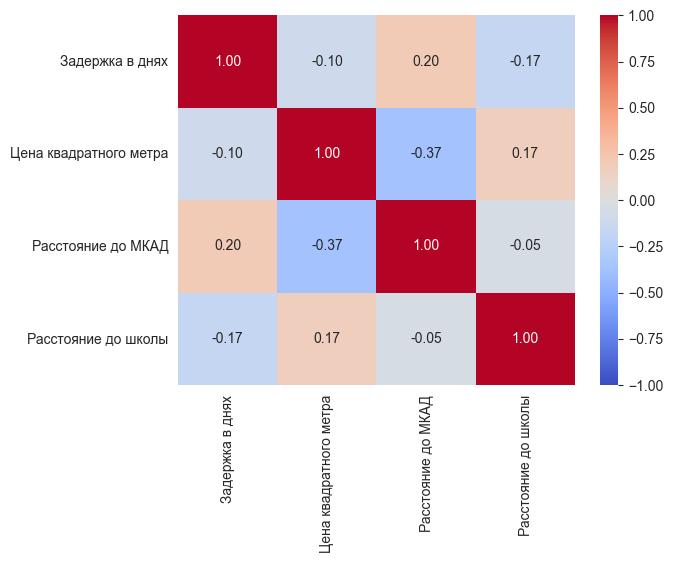

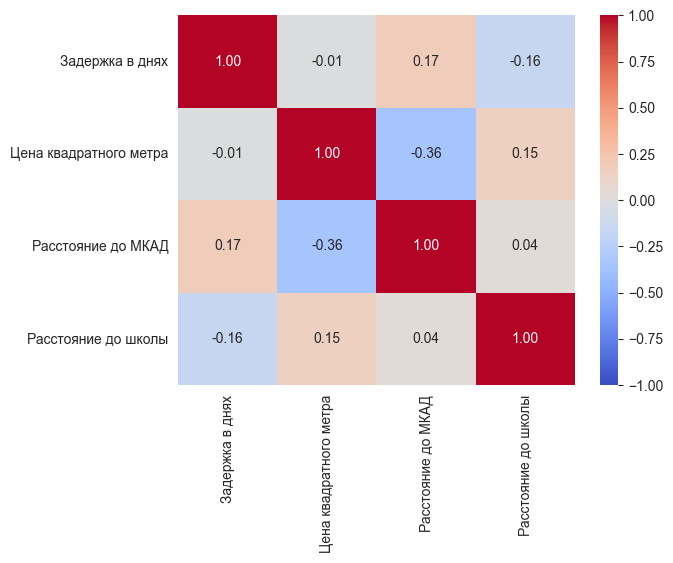

In [18]:
corr_type = 'spearman'

df = deals[['Задержка в днях', 'Цена квадратного метра', 'Расстояние до МКАД', 'Расстояние до школы']]

mat = df.corr(method=corr_type)
sns.heatmap(data=mat, vmin=-1, vmax=1, cmap='coolwarm', annot=True, fmt=".2f")
plt.show()


mat, _ = get_partial_corr_mat(df, corr_type=corr_type)
sns.heatmap(data=mat, vmin=-1, vmax=1, cmap='coolwarm', annot=True, fmt=".2f")
plt.show()



In [18]:
sns.boxplot(data=)